In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy import interpolate, optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import helper
import os
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fit_results_path = '../model_fit_results'
exp_measures = pd.read_csv('../data/measures.csv')

First, calculate the group RT mean values based on vincentized distributions

In [110]:
def get_vincentized_rt_mean(exp_measures, condition):
    print(condition)
    condition_data = exp_measures[(exp_measures.is_turn_decision) 
                                    & (exp_measures.d_condition==condition['d_condition']) 
                                    & (exp_measures.tta_condition==condition['tta_condition'])]
    class condition_vincent_average(scipy.stats.rv_continuous):
            def _cdf(self, x):
                q = np.linspace(0.0, 1.0, 11)
                condition_quantiles = condition_data.groupby('subj_id').apply(lambda d: np.quantile(a=d.RT, q=q)).mean()
                cdf_vincent = interpolate.interp1d(condition_quantiles, q, bounds_error=False, fill_value=(0,1))
                return cdf_vincent(x)

    cond_vincent=condition_vincent_average(name="empricial vincentized RT distribution")
    return(np.nan if len(condition_data)<3 else cond_vincent.mean())

# def save_group_means_by_condition(exp_measures):
conditions = [{'d_condition': d, 'tta_condition': TTA}
          for d in sorted(exp_measures.d_condition.unique()) 
          for TTA in sorted(exp_measures.tta_condition.unique())]
rt_means = pd.DataFrame(conditions)

get_rt_mean = lambda condition: get_vincentized_rt_mean(exp_measures, condition)
rt_means['RT'] = [get_rt_mean(condition) for condition in conditions]
rt_means.to_csv('rt_group_means.csv', index=False) 

{'d_condition': 90.0, 'tta_condition': 4.0}
{'d_condition': 90.0, 'tta_condition': 5.0}
{'d_condition': 90.0, 'tta_condition': 6.0}
{'d_condition': 120.0, 'tta_condition': 4.0}
{'d_condition': 120.0, 'tta_condition': 5.0}


C:\Users\Arkady\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1695: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


{'d_condition': 120.0, 'tta_condition': 6.0}
{'d_condition': 150.0, 'tta_condition': 4.0}
{'d_condition': 150.0, 'tta_condition': 5.0}
{'d_condition': 150.0, 'tta_condition': 6.0}


In [102]:
def get_psf_ci(data):
    # psf is a psychometric function
    # ci is a dataframe with confidence intervals for probability per coherence
    tta_conditions = np.sort(data.tta_condition.unique())
    
    psf = np.array([len(data[(data.is_turn_decision) & (data.tta_condition==tta_condition)]) 
                                            / len(data[data.tta_condition==tta_condition]) 
                        if len(data[(data.tta_condition==tta_condition)]) > 0 else np.NaN 
                    for tta_condition in np.sort(data.tta_condition.unique())])

    ci = pd.DataFrame(psf, columns=['p_turn'], index=tta_conditions)

    n = [len(data[(data.tta_condition==tta_condition)]) for tta_condition in tta_conditions]
    ci['ci_l'] = ci['p_turn'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_turn'] + np.sqrt(psf*(1-psf)/n)

    return ci.reset_index().rename(columns={'index': 'tta_condition'})

def get_rt_mean_sem(data, n_cutoff=2):
    mean = data.groupby('tta_condition')['RT'].mean()
    sem = data.groupby('tta_condition')['RT'].apply(lambda x: scipy.stats.sem(x, axis=None, ddof=0))
    n = data.groupby('tta_condition').size()
    data_mean_sem = pd.DataFrame({'RT_mean': mean, 'RT_sem': sem, 'n': n}, index=mean.index)
    data_mean_sem = data_mean_sem[data_mean_sem.n>n_cutoff]
    return(data_mean_sem)

# Model diagram

In [49]:
def get_trace():   
    noise = np.random.randn(len(t))
    drift = alpha*(tta-tta_crit+beta*(d-d_crit))
    dx = drift * dt + noise * np.sqrt(dt)
    x = np.append([0], np.cumsum(dx)[:-1])
    nd_time_idx = int(np.random.uniform(nd_time_mean-nd_halfwidth, nd_time_mean+nd_halfwidth) // dt)
    nd_time = t[nd_time_idx]
    
    return x

def generate_model_traces():
    is_two_correct = False
    while not is_two_correct:
        trials = [get_trace() for i in range(3)]
        is_two_correct = (np.sum([1 if x[-1]>0 else 0 for x in trials]) == 2)
    pd.DataFrame(trials).to_csv('ddm_traces.csv')

In [64]:
def plot_model_traces():
    alpha = 0.98
    tta_crit = 4.54
    beta = 0.04479
    d_crit = 126.6
    b_0 = 1.2
    k = 0.26
    nd_time_mean = 0.328
    nd_halfwidth = 0.227

    tta_condition = 6
    d_condition = 120

    v_condition = d_condition / tta_condition
    dt = 0.0001
    t = np.arange(0, 1.0, dt)
    d = d_condition - v_condition*t

    fig, (ax_rate, ax) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [1, 3]}, dpi=150, sharex=True)

    ax.annotate(r'$dx = \alpha(TTA + \beta d - \theta_{crit}) dt + dW$', xy=(0,0), xytext=(0.1, 0.2),
                 arrowprops=dict(arrowstyle='<-', connectionstyle='arc3'), fontsize=16)

    ax.text(0.6, 0.7, 'Turn', color='#4052ac', alpha=0.6, fontsize=16)
    ax.text(0.6, -0.75, 'Wait', color='#e6263d', alpha=0.6, fontsize=16)
    ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])

    for tta_condition in [4, 6]:
        tta = tta_condition - t
        boundary = b_0/(1+np.exp(-k*(tta-tta_crit)))
        ax.plot(t, boundary, ls='--', color='gray', alpha=0.6)
        ax.plot(t, -boundary, ls='--', color='gray', alpha=0.6)
        ax.text(0.78, 0.35+0.2*(tta_condition-4), r'TTA$|_{t=0}$=%is' % (tta_condition), color='grey', alpha=0.6, fontsize=16)

    trials = [x[1].values[1:] for x in pd.read_csv('ddm_traces.csv').iterrows()]

    for x in trials:
        response_time_idx = np.where(abs(x)>boundary)[0][0]
        response_time = t[response_time_idx]
        ax.plot(t[t<=response_time][::2], x[t<=response_time][::2], lw=1.0, alpha=0.4, 
                color='#4052ac' if x[response_time_idx]>0 else '#e6263d')
        ax.plot(t[t==response_time], x[t==response_time], ls='', alpha=0.8, marker='o', ms=4,
                color='#4052ac' if x[response_time_idx]>0 else '#e6263d')
        ax.set_xlabel(r'Time $t$', fontsize=14)
        ax.set_ylabel(r'Accumulated evidence $x$', fontsize=14)

    ax_rate.plot(t, tta+beta*d, color='#50596A', alpha=0.7)
    ax_rate.axhline(tta_crit+beta*d_crit, color='grey', alpha=0.5, ls='--', xmin=0.05, xmax=0.95)
    ax_rate.set_ylabel(r'$TTA + \beta d$', fontsize=16)
    ax_rate.set_ylim((8,12))
    ax_rate.text(0.05, 9.5, r'$\theta_{crit}$', color='grey', alpha=0.6, fontsize=16)

    sns.despine(offset=2, trim=True)
    plt.tight_layout()
    plt.savefig('../output/fig_model_diagram.pdf', bbox_inches='tight')

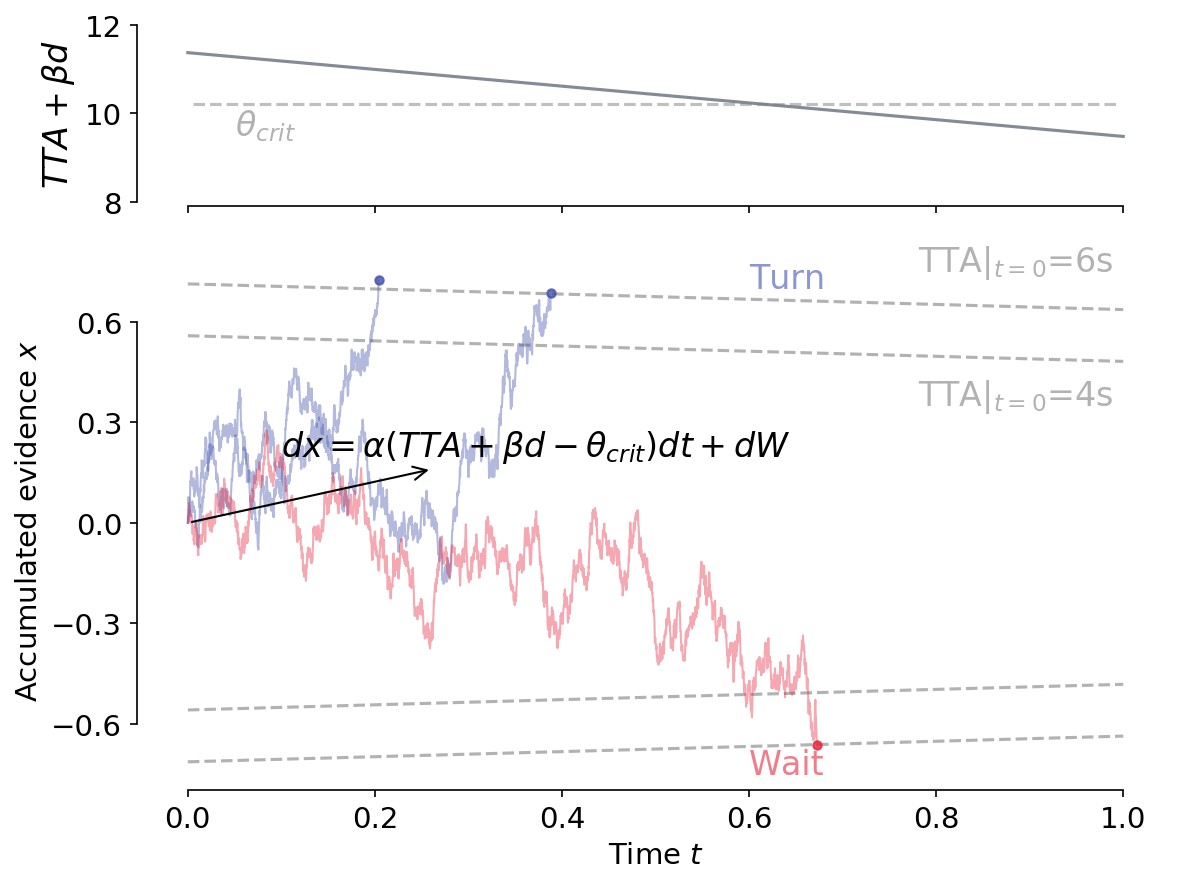

In [65]:
plot_model_traces()

# Trial timeline

In [67]:
exp_data = pd.read_csv('../data/processed_data.csv', index_col=['subj_id', 'session', 'route', 'intersection_no'])
traj_id = (129, 1, 2, 5)
traj = exp_data.loc[traj_id]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


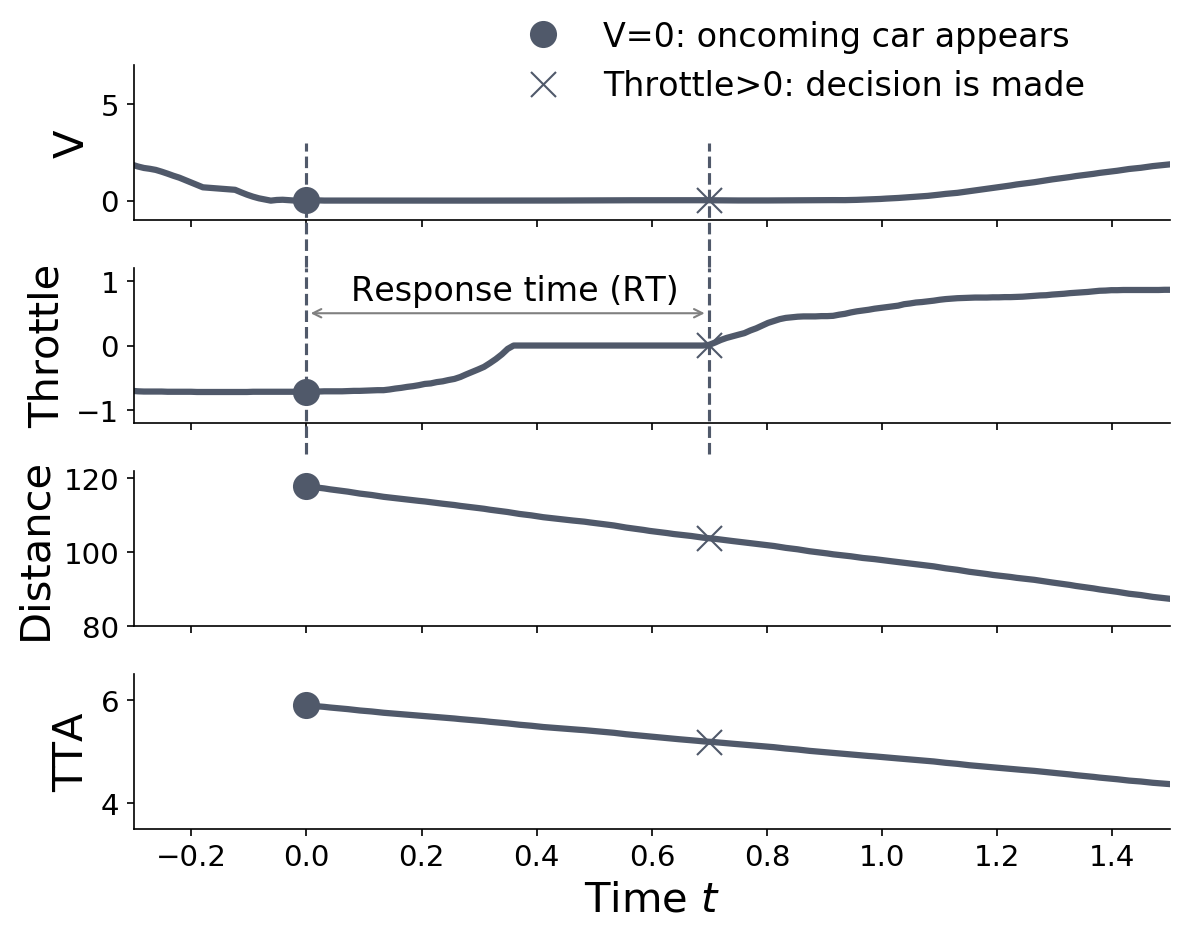

In [68]:
def plot_traj(traj, ax=None):
    color='#50596A'
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    traj.loc[:, 't'] -= traj.t.values[idx_bot_spawn]
    
    fig, axes = plt.subplots(4, 1, figsize=(8,6), dpi=150, sharex=True)
    ms = 12
    lw=3
    axes[0].plot(traj.t, traj.ego_v, color=color, lw=lw)
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[0].set_ylabel('V')
    axes[0].set_ylim((-1, 7))
    
    for x in [traj.t[idx_bot_spawn], traj.t[idx_response]]:
        axes[0].axvline(x=x, ymin=-0.3, ymax=0.5, c=color, ls='--', clip_on=False)
        axes[1].axvline(x=x, ymin=-0.2, ymax=1, c=color, ls='--', clip_on=False)
    
    axes[1].annotate(s='', xy=(traj.t[idx_bot_spawn], 0.5), xytext=(traj.t[idx_response], 0.5), 
                     arrowprops=dict(arrowstyle='<->', color='0.5'))
    axes[1].text(.21, .79, 'Response time (RT)', transform=axes[1].transAxes, fontsize=16)
    
    throttle_brake = traj.throttle-traj.brake
    axes[1].plot(traj.t, throttle_brake, color=color, lw=lw)
    axes[1].plot(traj.t[idx_bot_spawn], throttle_brake[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[1].plot(traj.t[idx_response], throttle_brake[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[1].set_ylabel('Throttle')
    axes[1].set_ylim((-1.2, 1.2))

    axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color=color, lw=lw)
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[2].set_ylabel('Distance')
    axes[2].set_ylim((80, 122))

    axes[3].plot(traj.t[idx_bot_spawn:], traj.tta[idx_bot_spawn:], color=color, lw=lw)
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color=color, ls='', marker='o', 
                 label='V=0: oncoming car appears', ms=ms)
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color=color, ls='', marker='x', 
                 label='Throttle>0: decision is made', ms=ms)
    axes[3].set_ylabel('TTA')
    axes[3].set_ylim((3.5, 6.5))

    axes[3].set_xlim((-0.3, 1.5))
    
    axes[3].set_xlabel('Time $t$')

    legend = fig.legend(loc='upper left', bbox_to_anchor=(0.4, 1.05), frameon=False)
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    
plot_traj(traj)
plt.savefig('../output/fig_trial_timeline.pdf', bbox_inches='tight')

# Model fit against data

In [148]:
model_measures_all_conditions = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_all_measures.csv'))

In [159]:
def plot_compare_model_exp(var, exp_data, model_measures, ylabel):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({'subj_id': str})
    group_rt_means = pd.read_csv('rt_group_means.csv') 
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    markers=['o', 's', '^']
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    
    subjects = model_measures.subj_id.unique()
    
    fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

    for subj_id, ax in zip(subjects, axes.flatten()):
        ax.set_title('All participants' if subj_id=='all' else 'P%s' % (subj_id), fontsize=16)
        for d_condition, color, marker in zip(d_conditions, colors, markers):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]
            
            if subj_id == 'all':
                data_subj_d_measures = exp_data[(exp_data.d_condition==d_condition)]
            else:
                data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
            
            if var=='is_turn_decision':
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], 
                    color=color, label=d_condition)
                psf_ci = get_psf_ci(data_subj_d_measures)            
                ax.plot(psf_ci.tta_condition, psf_ci.p_turn, ls='', marker=marker, ms=9, color=color, zorder=10)
                ax.vlines(x=psf_ci.tta_condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
            elif var=='RT':
                data_subj_d_measures = data_subj_d_measures[data_subj_d_measures.is_turn_decision]
                if subj_id=='all':
                    cond_group_rt_means = group_rt_means[(group_rt_means.d_condition==d_condition)]
                    ax.plot(cond_group_rt_means.tta_condition, cond_group_rt_means.RT, 
                            ls='', lw=1, marker=marker, ms=9, color=color)
                else:
                    if len(data_subj_d_measures)>0:
                        data_mean_sem = get_rt_mean_sem(data_subj_d_measures)
                        ax.errorbar(data_mean_sem.index, data_mean_sem.RT_mean, yerr=data_mean_sem.RT_sem, 
                                    ls='', marker=marker, ms=9, color=color)
                # Model
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], 
                    color=color, label=d_condition)

                ax.set_xticklabels([4, 5, 6])
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
            else:
                raise(ValueError)

        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label='Data, d=%im' % (d_condition)) 
                       for d_condition, color, marker in zip(d_conditions, colors, markers)] 
                       + [Line2D([0], [0], color='grey', label='Model fits')])

    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.15, 0.55), fontsize=16, frameon=False)

    fig.text(0.4, -0.05, 'Time-to-arrival (TTA), s', fontsize=18)
    fig.text(-0.02, 0.3, ylabel, fontsize=18, rotation=90)

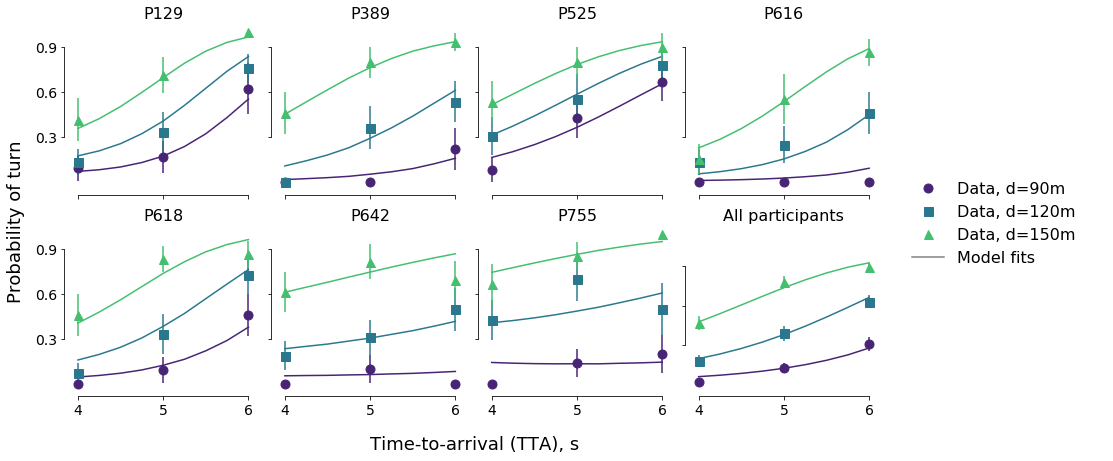

In [161]:
plot_compare_model_exp('is_turn_decision', exp_measures, model_measures_all_conditions, 'Probability of turn')
plt.savefig('../output/fig_p_turn.pdf', bbox_inches='tight')

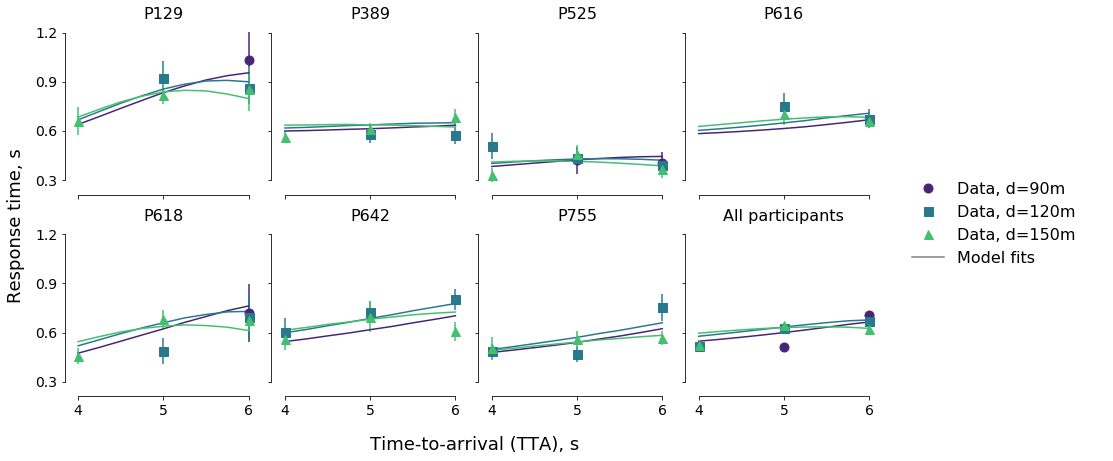

In [162]:
plot_compare_model_exp('RT', exp_measures, model_measures_all_conditions, 'Response time, s')
plt.savefig('../output/fig_RT.pdf', bbox_inches='tight')

# RT distributions

In [141]:
def plot_vincentized_rt_pdf(exp_data, model_rts, cumulative=False):
    fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)
    conditions = [{'d': d, 'TTA': TTA}
                  for d in sorted(exp_data.d_condition.unique()) 
                  for TTA in sorted(exp_data.tta_condition.unique())]
#     q = np.linspace(0.01, 0.99, 10)
    q = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    for (ax, condition) in zip(axes.flatten(), conditions):
        if (((condition['d'] == 90) & (condition['TTA'] == 6)) 
            | ((condition['d'] == 120) & (condition['TTA'] == 5)) 
            | ((condition['d'] == 150) & (condition['TTA'] == 4))):
            ax.text(0.5, 1.02, 'TTA=%is' % condition['TTA'], fontsize=16, transform=ax.transAxes, 
                        horizontalalignment='center', verticalalignment='center')

        if condition['TTA'] == 6:
            ax.text(1.0, 0.5, 'd=%im' % condition['d'], fontsize=16, transform=ax.transAxes, rotation=-90, 
                horizontalalignment='center', verticalalignment='center')
        
        condition_data = exp_data[(exp_data.is_turn_decision) 
                            & (exp_data.d_condition==condition['d']) 
                            & (exp_data.tta_condition==condition['TTA'])]
        if len(condition_data) >= 25:
            p_turn = (len(condition_data)
                      / len(exp_data[(exp_data.d_condition==condition['d']) & (exp_data.tta_condition==condition['TTA'])]))
#             ax.text(0.65, 0.2, 'n=%i' % (len(condition_data)), fontsize=12, transform=ax.transAxes,  
#                horizontalalignment='center', verticalalignment='center')
            
            condition_quantiles = condition_data.groupby('subj_id').apply(lambda d: np.quantile(a=d.RT, q=q)).mean()
            rt_range = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
            step = rt_range[1] - rt_range[0]
            rt_grid = np.concatenate([rt_range[:3]-3*step, rt_range, rt_range[-3:]+step*3])
            vincentized_cdf = np.interp(rt_grid, condition_quantiles, q, left=0, right=1)
    
            if cumulative:
                ax.plot(rt_grid, vincentized_cdf, label='Data', color='C1', ls='', marker='o')
#                 ax.plot(condition_quantiles, q, label='Data', color='C1', ls='', marker='o')
                ax.set_ylim([-0.05, 1.1])
                ax.set_yticks([0.0, 0.5, 1.0])
            else:
                _, data_pdf = np.histogram(condition_data.RT, bins=rt_grid)
                vincentized_pdf = differentiate(t=rt_grid, x=vincentized_cdf)
                ax.plot(rt_grid, vincentized_pdf, label='Data', color='C1')
            
            if not model_rts is None:
                condition_rts = model_rts[(model_rts.subj_id=='all') 
                                        & (model_rts.d_condition==condition['d']) 
                                        & (model_rts.tta_condition==condition['TTA'])]
                ax.plot(condition_rts.t, condition_rts.rt_corr_pdf, label='Model', color='grey')
        else:
            ax.set_axis_off()
            
        ax.set_xlabel('')
        ax.set_xlim((0, 1.5))
        sns.despine(offset=5, trim=True)

    fig.text(0.43, 0.04, 'Response time', fontsize=16)
    fig.text(0.04, 0.2, 'CDF' if cumulative else 'PDF', fontsize=16, rotation=90)
    
    return fig, axes

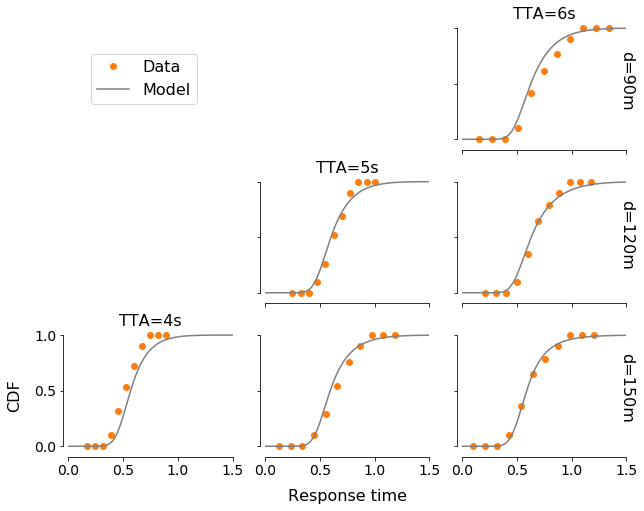

In [142]:
model_rts = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_all_rt_cdf.csv'))
fig, axes = plot_vincentized_rt_pdf(exp_measures, model_rts, cumulative=True)
fig.legend(labels=['Data', 'Model'], loc='center', bbox_to_anchor=(0.2, 0.75), fontsize=16, frameon=True)
plt.savefig('../output/fig_RT_dist.pdf', bbox_inches='tight')

# Model cross-validation

In [4]:
model_measures_cross_validation_8 = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_8_measures.csv'))
model_measures_cross_validation_4 = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_4_measures.csv'))

In [123]:
def plot_cross_validation(exp_data, model_measures):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({'subj_id': str})

    d_conditions = [90, 120, 150]
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    markers=['o', 's', '^']
    data_color='grey'
    model_color='grey'
    marker_size=10
    marker_offset = 0.1
    
    subjects = exp_data.subj_id.unique()
    subfigures = [(var, subj_id) for var in ['is_turn_decision', 'RT'] for subj_id in subjects]
    
    fig, axes = plt.subplots(2, 7, figsize=(14,6), sharex='col', sharey='row')

    for (var, subj_id), ax in zip(subfigures, axes.flatten()):
        if var=='is_turn_decision':
            ax.set_title('All participants' if subj_id=='all' else 'P%s' % (subj_id), fontsize=16)
        for d_condition, marker, color in zip(d_conditions, markers, colors):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]
            
            if subj_id == 'all':
                data_subj_d_measures = exp_data[(exp_data.d_condition==d_condition)]
            else:
                data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
            
            if var=='is_turn_decision':
                # Model
                ax.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures[var], 
                            color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')  
                
                # Data
                psf_ci = get_psf_ci(data_subj_d_measures)     
                ax.plot(psf_ci.tta_condition-marker_offset, psf_ci.p_turn, ls='', lw=1, marker=marker, 
                        ms=marker_size, color=color, zorder=10)
                ax.vlines(x=psf_ci.tta_condition-marker_offset, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, 
                          color=color, alpha=0.6, zorder=10)
            elif var=='RT':
                # Model
                ax.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures[var], 
                        color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')
                
                # Data
                data_subj_d_measures = data_subj_d_measures[data_subj_d_measures.is_turn_decision]
                if len(data_subj_d_measures)>0:
                    data_mean_sem = get_rt_mean_sem(data_subj_d_measures)
                    ax.errorbar(data_mean_sem.index-marker_offset, data_mean_sem.RT_mean, yerr=data_mean_sem.RT_sem, 
                                ls='', lw=1, marker=marker, ms=marker_size, color=color, ecolor=color)
                ax.set_ylim((0.3, 1.2))
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])

            else:
                raise(ValueError)

        ax.set_xticks([4, 5, 6])
        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=1, ls='--', fillstyle='none', label='Model predictions,') 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)] 
                       + [Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=0, label='data, d=%im' % (d_condition)) 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)])

    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 1.3), fontsize=16, handlelength=1.5, columnspacing=0.2,
               frameon=False, ncol=2)

    fig.text(0.4, -0.05, 'Time-to-arrival (TTA), s', fontsize=16)
    fig.text(-0.01, 0.55, 'Probability of turn', fontsize=16, rotation=90)
    fig.text(-0.01, 0.15, 'Response time', fontsize=16, rotation=90)

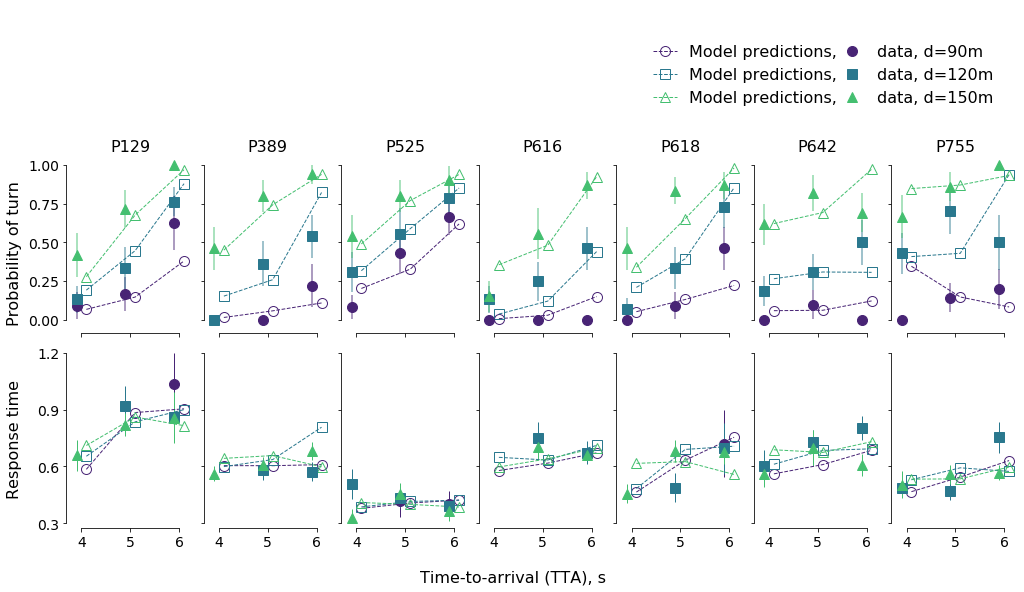

In [124]:
plot_cross_validation(exp_measures, model_measures_cross_validation_8)
plt.savefig('../output/fig_cross_validation_8.png', bbox_inches='tight')

In [143]:
def plot_cross_validation_per_subj(exp_data, model_measures, subj_id):
    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    markers=['o', 's', '^']
    marker_size=10
    marker_offset = 0.1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    
    if not subj_id=='all':
        fig.suptitle('P%s' % (subj_id), fontsize=16)
    
    group_rt_means = pd.read_csv('rt_group_means.csv') 
    
    for d_condition, marker, color in zip(d_conditions, markers, colors):
        model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                               & (model_measures.d_condition==d_condition)]

        if subj_id == 'all':
            data_subj_d_measures = exp_data[(exp_data.d_condition==d_condition)]
            cond_group_rt_means = group_rt_means[(group_rt_means.d_condition==d_condition)]
        else:
            data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]

        # Model
        ax1.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures['is_turn_decision'], 
                    color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')  

        # Data
        psf_ci = get_psf_ci(data_subj_d_measures)     
        ax1.plot(psf_ci.tta_condition-marker_offset, psf_ci.p_turn, ls='', lw=1, marker=marker,
                ms=marker_size, color=color, zorder=10)
        ax1.vlines(x=psf_ci.tta_condition-marker_offset, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, 
                  color=color, alpha=0.6, zorder=10)

        # Model
        ax2.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures['RT'], 
                color=color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size, fillstyle='none')

        # Data
        data_subj_d_measures = data_subj_d_measures[data_subj_d_measures.is_turn_decision]
        if subj_id=='all':            
            ax2.plot(cond_group_rt_means.tta_condition-marker_offset, cond_group_rt_means.RT, 
                            ls='', lw=1, marker=marker, ms=marker_size, color=color)
        else:
            if len(data_subj_d_measures)>0:
                data_mean_sem = get_rt_mean_sem(data_subj_d_measures, vincentized=True)
                ax2.errorbar(data_mean_sem.index-marker_offset, data_mean_sem.RT_mean, yerr=data_mean_sem.RT_sem, 
                            ls='', lw=1, marker=marker, ms=marker_size, color=color, ecolor=color)                   
    
    fig.text(0.35, -0.05, 'Time-to-arrival (TTA), s', fontsize=16)
    
    ax1.set_xticks([4, 5, 6])
    ax2.set_xticks([4, 5, 6])
    
    ax1.legend().remove()
    ax2.legend().remove()
    
    ax1.set_ylabel('Probability of turn', fontsize=16)
    ax2.set_ylabel('Response time', fontsize=16)

    ax1.set_ylim((0.0, 1.0))
    
    ax2.set_ylim((0.4, 0.8))
    
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=1, ls='--', fillstyle='none', label='Model predictions,') 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)] 
                       + [Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=0, label='data, d=%im' % (d_condition)) 
                           for d_condition, marker, color in zip(d_conditions, markers, colors)])

    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16, handlelength=1.5, columnspacing=0.2,
               frameon=False, ncol=2)

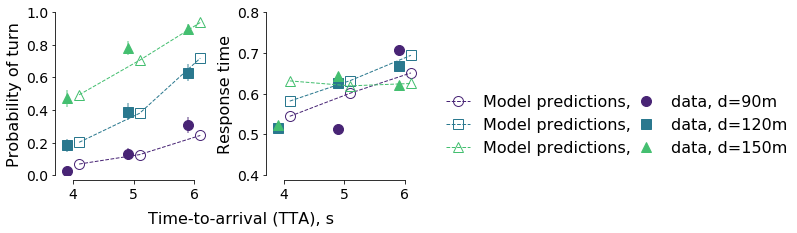

In [144]:
plot_cross_validation_per_subj(exp_measures, model_measures_cross_validation_8, subj_id='all')
plt.savefig('../output/fig_cross_validation_8_vincent.pdf', bbox_inches='tight')

### Cross-validation on 4 conditions

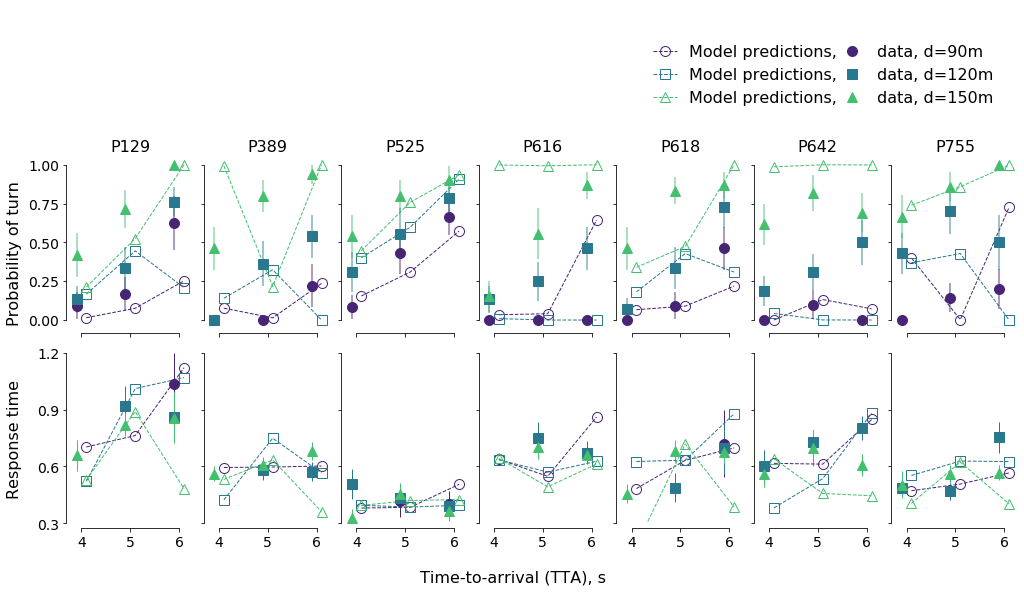

In [127]:
plot_cross_validation(exp_measures, model_measures_cross_validation_4)

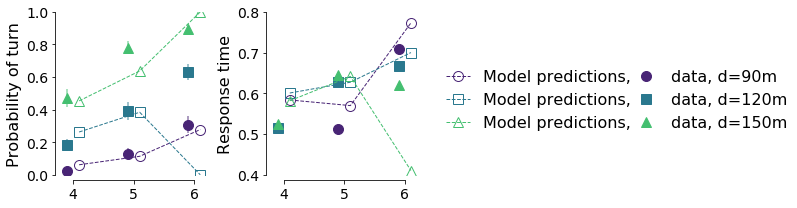

In [128]:
plot_cross_validation_per_subj(exp_measures, model_measures_cross_validation_4, subj_id='all')